In [4]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import os
import sys
import itertools
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
project_root = os.path.abspath(os.getcwd())

data_dir = os.path.join(os.path.dirname(project_root))

results_dir = os.path.join(data_dir, 'results')

figures_dir = os.path.join(data_dir, 'figures')

# Summer month

results_basecase_summer = pd.read_csv(os.path.join(results_dir, 'results_basecase_summer.csv'),sep=',')
results_basecase_winter = pd.read_csv(os.path.join(results_dir, 'results_basecase_winter.csv'), sep=',')
results_case_1_winter = pd.read_csv(os.path.join(results_dir, 'results_case_1_winter.csv'), sep=',')
results_case_2_summer = pd.read_csv(os.path.join(results_dir,'results_case_2_summer.csv'), sep=',')
results_case_2_winter = pd.read_csv(os.path.join(results_dir,'results_case_2_winter.csv'), sep=',')
results_case_3_winter = pd.read_csv(os.path.join(results_dir,'results_case_3_winter.csv'), sep=',')
results_case_3_summer = pd.read_csv(os.path.join(results_dir,'results_case_3_summer.csv'), sep=',')


In [6]:
#print column names of all the dfs
print('results_basecase_summer' , results_basecase_summer.columns)
print('results_case_1_winter' , results_case_1_winter.columns)
print('results_case_2_summer' , results_case_2_summer.columns)
print('results_case_3_summer' , results_case_3_summer.columns)#

results_basecase_summer Index(['timestamp', 'Spotmarket_(EUR/kWh)', 'Inflexible_Demand_(kWh)',
       'PV_energy_production_kWh', 'ev_at_home_binary', 'distance_driven',
       'ev_home_availability', 'weekday', 'Allowed_WM_summer', 'Allowed_dryer',
       'Total_Demand', 'Dishwasher_Start', 'Dishwasher_On',
       'Washing_Machine_Start', 'Washing_Machine_On', 'Dryer_Start',
       'Dryer_On', 'EV_SOC', 'EV_Charging', 'EV_On', 'Demand_Level',
       'Penalty_Cost', 'Electricity_Cost', 'Total_Cost'],
      dtype='object')
results_case_1_winter Index(['timestamp', 'Spotmarket_(EUR/kWh)', 'Inflexible_Demand_(kWh)',
       'PV_energy_production_kWh', 'Heating_Demand_(kWh)', 'ev_at_home_binary',
       'distance_driven', 'ev_home_availability', 'weekday',
       'Allowed_WM_summer', 'Allowed_dryer', 'Total_Demand',
       'Dishwasher_Start', 'Dishwasher_On', 'Washing_Machine_Start',
       'Washing_Machine_On', 'Dryer_Start', 'Dryer_On', 'EV_SOC',
       'EV_Charging', 'EV_On', 'Heatpump_P

### Plot PV Comparison Case 2 - Case 3

In [110]:
def plot_pv_comparison(
    df1,
    df2,
    save_filename,
    min_time,
    max_time,
    figsize=(20, 8)
):
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(ncols=2, sharey=True, figsize=figsize)

    datasets = [df1, df2]
    labels = ["Case 2 - Curtailed & PV2H", "Case 3 - PV2G & PV2H"]
    y_labels = ["Energy (kWh)", ""]
    energy_cols = [["Curtailed", "PV2H"], ["PV2G", "PV2H"]]

    color_map_list = [
        {"Curtailed": "tab:blue", "PV2H": "tab:green"},
        {"PV2G": "orange", "PV2H": "tab:green"},
    ]

    all_handles = []
    all_labels = []

    for idx, (df, ax, energy_set, title) in enumerate(zip(datasets, axes, energy_cols, labels)):
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.iloc[min_time:max_time]
        timestamps = df['timestamp']

        # Plot energy lines manually to capture handles
        for col in energy_set:
            line, = ax.plot(
                timestamps,
                df[col],
                drawstyle='steps-post',
                label=col,
                color=color_map_list[idx][col]
            )
            all_handles.append(line)
            if col not in all_labels:
                all_labels.append(col)

        ax.set_ylabel(y_labels[idx])
        ax.set_xlabel("Date")
        ax.set_title(title, fontsize=14)
        ax.grid(False)

        ax.set_xlim(timestamps.iloc[0].normalize(), timestamps.iloc[-1].normalize() + pd.Timedelta(days=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d.%m'))
        ax.xaxis.set_major_locator(mdates.DayLocator())

        # For the right subplot (idx == 1), completely remove left ticks and spine
        if idx == 1:
            ax.yaxis.set_visible(False)
            ax.spines["left"].set_visible(False)
        else:
            # Keep left subplot as is
            ax.tick_params(axis='y', which='both', left=True, labelleft=True)

        # Spotmarket price on twin axis
        ax2 = ax.twinx()
        spot_line, = ax2.plot(
            timestamps,
            df['Spotmarket_(EUR/kWh)'],
            '--',
            color='brown',
            label='Spotmarket Price'
        )
        ax2.grid(False)

        if idx == 1:
            ax2.set_ylabel("Spotmarket Price (EUR/kWh)", color='black', labelpad=10)
            ax2.tick_params(axis='y', labelright=True, labelcolor='black')
        else:
            ax2.set_ylabel("")
            ax2.set_yticklabels([])
            ax2.tick_params(axis='y', labelright=False, length=0)
            ax2.spines["right"].set_visible(False)

        all_handles.append(spot_line)
        all_labels.append("Spotmarket Price")

    # Deduplicate while preserving order
    seen = set()
    final_handles, final_labels = [], []
    for h, l in zip(all_handles, all_labels):
        if l not in seen:
            final_handles.append(h)
            final_labels.append(l)
            seen.add(l)

    # Deduplicate while preserving order
    seen = set()
    final_handles, final_labels = [], []
    for h, l in zip(all_handles, all_labels):
        if l not in seen:
            final_handles.append(h)
            final_labels.append(l)
            seen.add(l)

    # Move "Spotmarket Price" to the end if it exists
    if "Spotmarket Price" in final_labels:
        idx = final_labels.index("Spotmarket Price")
        # Pop and append at the end
        spot_handle = final_handles.pop(idx)
        spot_label = final_labels.pop(idx)
        final_handles.append(spot_handle)
        final_labels.append(spot_label)

    # Global bottom legend
    fig.legend(
        handles=final_handles,
        labels=final_labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.05),
        ncol=len(final_labels),
        fontsize=16,
        frameon=True
    )

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig(os.path.join(figures_dir, save_filename), dpi=400, bbox_inches='tight')
    plt.show()

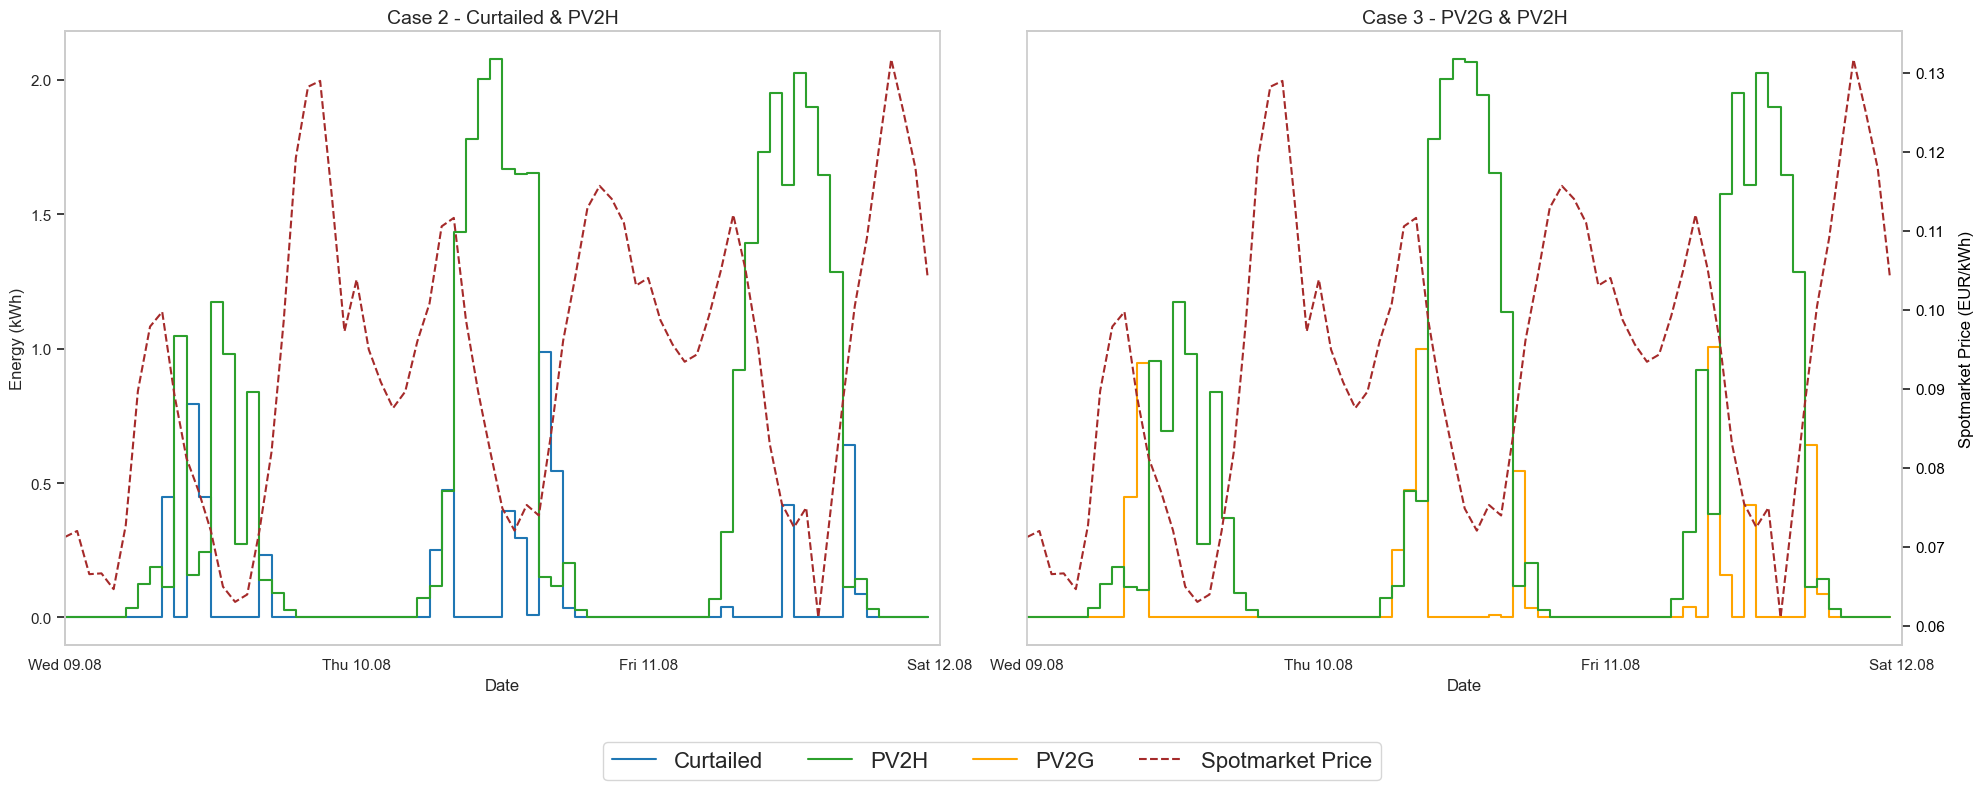

In [111]:
plot_pv_comparison(
    df1=results_case_2_summer,
    df2=results_case_3_summer,
    save_filename="PV_comparison.png",
    min_time=24 * 8,
    max_time=24 * 11
)